
# Команда 9 🥷

Информация о компании
1. Отрасль и направления деятельности: EdTech, сервис-онлайн
образования

2. О проекте: Создание и оформление отчёта целей обучения студентов
Яндекс Практикума для презентации топ-менеджменту Яндекс
Практикума.

3. Цели отчёта:  
* определить нормальные и найти аномальные показатели 
* определить коррелирующие параметры, построить портреты студентов,
сравнить их, чтобы выделить значимые закономерности
* сегментировать студентов (по 2м и более показателям), выявить
особенности сегментов
* сформулировать на основе данных гипотезы по улучшению
выстраивания помощи студентам в достижении их целей,
* оформить выводы и гипотезы аналитиков с помощью инструментов
фигмы для презентации руководству Яндекс Практикума.

##### Описание данных

**hackathon_metrics**  

`profession_name` — код профессии  
`user_id` — уникальный id пользователя  
`lp_avg_user` — средний learning performance (Первые, более высокие значения в таблице с фри-трека, последние с курса, наиболее актуально находящееся в таблице ниже)  
`question_title` — текст вопроса  
`user_answer` — ответ пользователя на вопрос  
`statement_content` — формулировка вопроса об уверенности в знаниях   
`value` — ответ на вопрос об уверенности в знаниях для расчёта learning experience индекса  

  
**data_goals_answers**

`question_title` — текст вопроса  
`question_type` — тип вопроса  
`user_id `— уникальный id пользователя  
`user_answer` — ответ пользователя на вопрос  
`answer_date` — время ответа  
`answer_id` — id ответа  
`cohort, current_cohort` — начальная и текущая когорта студента  
`course_name, topic_name, lesson_name` — курс, тема и урок, на котором студент отвечает на вопрос (У нас значения должны быть Трудоустройство-Трудоустройство-Цель обучения, т.к. мы изучаем именно это)    
`original_segment, current_segment — b2c/b2b/b2g` — из какого сегмента был/стал студент — сам является клиентом, его обучение оплачивается бизнесом или государством  
`profession_name` — код профессии  
`statement_content` — формулировка вопроса об уверенности в знаниях (в этой таблице нету)  
`slide_position` — страница опроса (не нужно для анализа)  

-----

# EDA

In [110]:
# pip 

# !pip install --quiet \
#   pymorphy2 \
#   pandas \
#   plotly

# %pip install --upgrade StandardScaler \
#   sklearn.decomposition.PCA

In [111]:
# Основные импорты

import pandas as pd
import numpy as np
import re
import os
import random
import textwrap
from scipy import stats 
from pymorphy2 import MorphAnalyzer
from pathlib import Path
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# кластеризация
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# random state
R = 12345

In [112]:
# графики

class Graphs:
    def __init__(self, template: str, family: str, axis_color: str) -> None:
        self.family = family
        self.axis_color = axis_color
        self.template = template
        self.text_size = 18
        self.tick_size = 8

    def save_graph(self, fig, format="svg") -> None:
        """
          save graphs
        """
        Path("images").mkdir(parents=True, exist_ok=True)
        counter = 0
        while True:
            counter += 1
            filename = "images/fig_{}.%s".format(counter) % format
            if os.path.exists(filename):
                continue
            else:
                fig.write_image(filename)
                break

    def layout_style(self, fig, **kwargs):
        """
          styles for graphs
        """
        font = dict(family=self.family,
                    size=self.text_size,
                    color=self.axis_color)

        return fig.update_layout(
                template=self.template,
                showlegend=False,
                title=go.layout.Title(text=kwargs["title"],
                                      xref="paper",
                                      x=0.5,
                                      font=font),
                xaxis=go.layout.XAxis(
                    tickfont=dict(size=self.tick_size),
                    title=go.layout.xaxis.Title(text=kwargs["xaxis_title"],
                                                font=font)),
                yaxis=go.layout.YAxis(
                    tickfont=dict(size=self.tick_size),
                    title=go.layout.yaxis.Title(text=kwargs["yaxis_title"],
                                                font=font)))

    def custom_heatmap(self, data, title: str, xaxis_title: str, yaxis_title: str):
      """
        heatmap 
      """
      fig = go.Figure(ff.create_annotated_heatmap(z=data.to_numpy().round(2),
                                                  x=list(data.index.values),
                                                  y=list(data.columns.values),
                                                  xgap=3, ygap=3,
                                                  zmin=-1, zmax=1,
                                                  colorscale="rainbow"))

      self.layout_style(fig=fig,
                        title=title,
                        xaxis_title=xaxis_title,
                        yaxis_title=yaxis_title)
      
      fig.update_xaxes(tickangle=90)

      return fig

# сегментация

class SegmentUsers:
  def __init__(self, df, prof_list, segment_list):
    self.data = df.copy()
    self.prof_list = prof_list
    self.segment_list = segment_list

  def segment_sep(self, current_segment, profession_name, user_answer):
    """
      creating row with segment
    """
    segment_list = [
        (
            "%s, %s" % (profession_name, current_segment),
            """
            current_segment == '%s' & profession_name == '%s' \
            & user_answer_1 == '%s' & question_title_1 != 'comment'
            """
        % (current_segment, profession_name, user_answer)
        )
      ]
    for segment, query in segment_list:
      rows = list(
          self.data
          .query(query)
          .agg(
              {
                  "user_id":"nunique",
                  "lp_avg_user":"mean",
                  "value":"mean",
                  "flag_segment_transfer":"mean",
                  "flag_cohort_transfer":"mean",
                  "question_title_1":"min",
                  "user_answer_2":"mean"
              }
          )
      )
      rows.insert(0, segment)
      rows.insert(1, user_answer)
      rows.insert(2, profession_name)
      rows.insert(3, current_segment)
    return rows

  def make_table(self, dataframe, user_answer):
    """
      make segments table 
    """
    for p in self.prof_list:
        for s in self.segment_list:
          if str(s) != "nan":
            row = self.segment_sep(current_segment=s,
                                   profession_name=p,
                                   user_answer=user_answer
                                   )
            dataframe.loc[len(dataframe),:] = row
            dataframe.fillna(0, inplace=True)

In [113]:
# общие функции

def popular_words(data):
  """
    popular words in answers
  """
  pattern = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
  column = list(data.dropna().drop_duplicates())
  morph = MorphAnalyzer()
  res = re.sub(pattern, ' ', str(column))
  words = []
  for i in res.split():
    word = morph.normal_forms(i)[0]
    words.append(word)
  words = [i for i in words if len(i) > 3]
  return words

def extract(file_id: str):
    """
      downloading from google drive
    """
    return pd.read_csv(
        "https://drive.google.com/uc?export=download&id=%s" % (file_id), 
        index_col=0)

def df_info(df):
    """
      dataframe information 
    """
    return (
        pd.DataFrame({
            "column_type": df.dtypes,
            "row_count": df.count(),
            "unique_count": df.nunique(),
            "duplicated_count": df.duplicated().sum(),
            "duplicated_pct": df.duplicated().mean(),
            "nan_count": df.isna().sum(),
            "nan_pct": df.isna().mean(),
            "min": df.min(numeric_only=True),
            "max": df.max(numeric_only=True),
            "mean": df.mean(numeric_only=True)
            })
        .sort_values(by='nan_count', ascending=False)
        .style.format({
            "unique_pct": "{:.1%}",
            "duplicated_pct": "{:.1%}",
            "nan_pct": "{:.1%}"
            })
        .set_caption("dataframe info")
        )

def customwrap(s,width=30):
    """
      add <br> in text when width=@width
    """
    return "<br>".join(textwrap.wrap(s,width=width))

def random_text(word, width):
  """
    random student text answer for treemap
  """
  text = random.choice(answers_text[answers_text.str.contains(word)].map(customwrap).to_list())
  while len(text) > width:
    text = random.choice(answers_text[answers_text.str.contains(word)].map(customwrap).to_list())
  return text

In [114]:
# ДАТАФРЕЙМЫ

name = ["hackathon_metrics", "data_goals_answers "]

hackathon_metrics = extract("1TLvkUoDw3AfRTyTM-38DTOyXeyNLKpdz")
data_goals_answers = extract("1AA168t9VrH4GHRSt8YC3YZDNSkpL7Vbe")

In [115]:
# Общие настройки для графиков, стиль, шрифт, цвета

grph = Graphs(
    template="plotly_white",
    family="San Francisco",
    axis_color="#000000"
)

In [116]:
# Таблица с метриками в нормальном виде

data_goals_answers["user_id"] = data_goals_answers["user_id"].astype(int)

hackathon_metrics = (
    hackathon_metrics
    .groupby("user_id", as_index=False)
    .agg(
        {
            "lp_avg_user":"last",
            "statement_content":"last",
            "value":"mean", 
            "question_title":"min",
            "user_answer":"mean"
        }
    )
)
hackathon_metrics["user_answer"] = hackathon_metrics["user_answer"].replace({0:np.nan})

In [117]:
# общий df

df = (
    pd
    .merge(
        data_goals_answers, 
        hackathon_metrics, 
        on="user_id", 
        how="left", 
        suffixes=['_1','_2']
    )
)

In [118]:
df.head(1)

user_id          answer_date                             answer_id   
0     3157  2023-09-01 10:43:00  41ac1a75-1f3b-44bd-a2f2-346c3bdef7b3  \

            cohort      course_name   current_cohort current_segment   
0  data_cohort_121  Трудоустройство  data_cohort_121             b2g  \

     lesson_name original_segment profession_name  ... question_type   
0  Цель обучения              b2g    data-analyst  ...      checkbox  \

  slide_position  statement_content_1       topic_name   
0              0                  NaN  Трудоустройство  \

                        user_answer_1 lp_avg_user   
0  определение профессиональной сферы    0.652222  \

                                 statement_content_2 value  question_title_2   
0  Моя уверенность в своих знаниях значительно по...  1.25               NaN  \

  user_answer_2  
0           NaN  

[1 rows x 21 columns]

In [119]:
df_info(df)

удалим **"topic_name", "course_name", "lesson_name", "statement_content_1",  "slide_position"** т.к. не несут полезной информации
      
* 15% пользователей ответили на вопрос: "Какова вероятность, что вы порекомендуете Практикум своим друзьям по шкале от 0 до 10, где 10 — обязательно порекомендую, 0 — не порекомендую ни за что?"
* средний lp_avg_user - 0.7
* 6 различный вопросов

добавим флаги для сменивших сегмент и когорту юзеров

In [120]:
# предобработка

df = df.drop(["topic_name","course_name","lesson_name","statement_content_1","slide_position"], axis=1)

df["answer_date"] = pd.to_datetime(df["answer_date"], format="%Y-%m-%d %H:%M:%S")
df["user_answer_1"] = df["user_answer_1"].str.lower()

# студенты сменившие segment 1-нет 0-да

df["flag_segment_transfer"] = (
    df
    .groupby("user_id")
    .apply(lambda x : x["original_segment"].isin(x["current_segment"]).astype('int'))
    .reset_index(level="user_id", drop=True)
)

# студенты сменившие cohort 1-нет 0-да
df["flag_cohort_transfer"] = (
    df
    .groupby("user_id")
    .apply(lambda x : x["cohort"].isin(x["current_cohort"]).astype('int'))
    .reset_index(level="user_id", drop=True)
)

In [121]:
# количество студентов сменивших segment
# 1-нет 0-да

df.groupby("flag_segment_transfer",as_index=False)["user_id"].nunique()

flag_segment_transfer  user_id
0                      0       85
1                      1     3464

In [122]:
# количество студентов сменивших cohort
# 1-нет 0-да

df.groupby("flag_cohort_transfer",as_index=False)["user_id"].nunique()

flag_cohort_transfer  user_id
0                     0      227
1                     1     3323

In [123]:
# столбцы переводим в числовые данные, для просмотра корреляции по каждому признаку

dff = df.copy()

for c in ["question_type", "current_segment", "profession_name"]:
  dff = pd.concat([dff, pd.get_dummies(dff[c])], axis=1)


columns_list = list(dff.columns)
remove_list = remove_list = ['user_id', 'answer_date', 'answer_id', 'cohort', 'current_cohort',
       'current_segment', 'original_segment', 'profession_name',
       'question_title_1', 'question_type', 'user_answer_1','statement_content_2','question_title_2' ]
for c in remove_list:
  columns_list.remove(c)

corr = dff[columns_list].corr()

In [124]:
# зависимость признаков ДЛЯ ВНУТРЕННЕЙ РАБОТЫ

fig = grph.custom_heatmap(corr,
                          title="Хитмап корреляция (внутренний график)",
                          xaxis_title=None,
                          yaxis_title=None)

fig.update_layout(width=800,height=500)
fig.show(config={"displayModeBar": False})

Высокой корреляции между признаками нет, слабая корреляция наблюдается между:  
`lp_avg_user` и `systems-analyst`  - 0.38  
`b2c` и `systems-analyst` 0.3  

`b2g` и `systems-analyst` - -0.3    

Количество ответов на вопросы по каждому типу:

In [125]:
# длинные вопросы заменим коротким тегом

questions = df["question_title_1"].unique()

replace_question = [
    "help", "comment", "goal", "work", "experience", "career_track"
]

for r, q in zip(replace_question, questions):
  print(r,"-",q,"\n")
  df.loc[df["question_title_1"].str.contains(q),"question_title_1"] = r

help - Для программы важно понять над чем вам нужно поработать. Не переживайте, вам будут доступны все опции. 

comment - Тут вы можете оставить свой комментарий, если не нашли подходящего варианта ответа. 

goal - Бывает, что во время обучения меняется его цель. Например, изначально вы не планировали менять работу, но влюбились в профессию. Может, произошли жизненные изменения или вам сложно определить цель. Чтобы мы поняли, как помочь, отметьте подходящее утверждение: 

work - Возможно вы нашли работу за время обучения? 

experience - В зависимости от опыта работы вам может понадобиться разный вид консультаций и помощи от команды сопровождения и трудоустройства. Для нас очень важен честный ответ и понимание вашего бэкграунда. 

career_track - Планируете ли вы записаться на Карьерный Трек? 



In [126]:
# таблицы с вопросами и количеством ответов

q = (
    df
    .query("question_type != 'text'")
    .groupby(["question_title_1","user_answer_1"], as_index=False)["user_id"]
    .nunique()
    .rename(columns={"user_id":"pop"})
).sort_values(by="pop", ascending=False)

for i in replace_question:
  if i != 'comment':
    display(q.query("question_title_1 == @i"))

question_title_1                                user_answer_1   pop
30             help                                       резюме  2683
26             help                         оформление портфолио  2602
29             help                    прохождение собеседований  2582
31             help                     решение тестовых заданий  2430
32             help                      сопроводительное письмо  2429
25             help          определение стратегии поиска работы  2308
27             help             оценка шансов на трудоустройство  2244
28             help          персональная карьерная консультация  1948
33             help                       устройство рынка труда  1748
22             help       как и куда можно расти как специалисту  1730
24             help           определение профессиональной сферы  1655
21             help                   как говорить про повышение  1237
23             help  не думаю, что вы можете мне с чем-то помочь   193

question_title_1                                    user_answer_1   pop
19             goal                                  сменить работу.  2306
16             goal       получить новые навыки для общего развития.   373
15             goal  получить новые знания, чтобы повысить зарплату.   349
17             goal              продвинуться по карьерной лестнице.   216
20             goal  структурировать уже полученные навыки и знания.   177
14             goal                нет определённой цели в обучении.    67
18             goal                            развить свой бизнес.     41

question_title_1      user_answer_1   pop
36             work                нет  2704
34             work  в активном поиске   572
35             work                 да   205

question_title_1                                      user_answer_1   pop
10       experience  нет опыта работы в it и в направлении анализа ...  2247
11       experience    от 1 года опыта работы в другом направлении it.   494
13       experience  от 1 до 3 лет опыта работы направлении анализа...   178
4        experience  более 3 лет опыта работы в направлении анализа...   160
5        experience  менее 1 года опыта работы в другом направлении...   142
7        experience  менее года опыта работы в направлении анализа ...   130
9        experience                нет опыта работы аналитиком и в it.    83
12       experience             от 1 до 3 лет опыта работы аналитиком.    48
3        experience               более 3 лет опыта работы аналитиком.    28
6        experience                менее года опыта работы аналитиком.    27
8        experience                нет опыта работы аналитиков и в it.    17

question_title_1                          user_answer_1   pop
0     career_track  да, планирую записаться после диплома  1934
1     career_track                      да, уже записался  1289
2     career_track                       нет, не планирую   305

In [127]:
# карта популярных слов в текстовых ответах
# текстовые ответы к каждому популярному слову выбираются случайно

answers_text = df.query("question_type == 'text'")["user_answer_1"].dropna()
popular_words_dict = Counter(popular_words(answers_text))

# топ слова
top_words = (
    pd.DataFrame(popular_words_dict, index=[0])
    .T
    .reset_index()
    .rename(columns={"index":"word", 0:"count"})
)

# первые символы
top_words["first_symbols"] = top_words["word"].apply(lambda x: x[:5])
top_words = (
    top_words
    .groupby("first_symbols")
    .agg({"word":"min","count":"sum"})
    .sort_values(by="count",ascending=False)
).query("word != 'хотеть'")[:10]

# к каждому популярному слову находим случайный текст ответа
for word in top_words["word"]:
  top_words.loc[top_words["word"].str.contains(word),"text"] = (
      "".join(random_text(word,350))
      )

fig = px.treemap(top_words,
                 path=["word", "text"],
                 values="count",
                 color="word",
                 color_discrete_sequence=px.colors.qualitative.Pastel2
)
grph.layout_style(fig=fig,
                  title="""
                    Популярные слова в ответах на вопросы в свободной форме
                    <br><sup>Случайный текстовый ответ от студента</sup>
                  """,
                  yaxis_title=None,
                  xaxis_title=None)
# fig.update_traces(marker=dict(cornerradius=5),marker_line_width=2)
fig.update_layout(width=1000,height=500)
fig.show(config={"displayModeBar": False})

Одни из самых часто встречающихся слов в текстовых ответах студентов это - `работа`, `найти`.
На графике представлены примеры таких ответов. Это поможет более детально понять какие у них цели и с какими проблемами они сталкиваются.

In [128]:
current_segment_count = (
    df
    .groupby(["profession_name","current_segment"], as_index=False)["user_id"]
    .agg(
        {
            "user_id":"nunique"
        }
    )
    .rename(columns=
            {
                "user_id":"pop",
                "lp_avg_user":"lp_avg_user_profession"
            }
    )
)

b2b = current_segment_count.query("current_segment == 'b2b'")
b2c = current_segment_count.query("current_segment == 'b2c'")
b2g = current_segment_count.query("current_segment == 'b2g'")

trace1 = go.Bar(x=b2b["profession_name"].unique(),
                y=b2b["pop"],
                name="b2b",
                text=b2b["pop"])
trace2 = go.Bar(x=b2c["profession_name"].unique(),
                y=b2c["pop"],
                name="b2c",
                text=b2c["pop"])
trace3 = go.Bar(x=b2g["profession_name"].unique(),
                y=b2g["pop"],
                name="b2g",
                text=b2g["pop"])

fig = go.Figure(data=[trace1,trace2,trace3])

grph.layout_style(fig=fig,
                  title="""
                        Распределение студентов по направлению обучения и типу оплаты
                        """,
                  xaxis_title="Направление",
                  yaxis_title="Количество") \
    .update_xaxes(categoryorder="total descending") \
    .update_yaxes(showgrid=False) 

fig.update_layout(barmode="stack",showlegend=True,width=800,height=400)
fig.update_traces(texttemplate="%{text}", textposition="inside")
fig.show(config={"displayModeBar": False})

В данной выборке из b2g оплаты только направления `data-analyst`, `data-scientist`, `data-analyst-plus`, `data-scientist-plus`.

По этим направлениям наибольшую часть составляют студенты с данным типом оплаты.

In [129]:
fig = px.histogram(df,
                   x="lp_avg_user", 
                   color="profession_name", 
                   nbins=120,
                   color_discrete_sequence=px.colors.qualitative.Pastel2
      )
fig.add_vline(x=np.median(df["lp_avg_user"].dropna()), 
              line_dash = "dash", 
              line_color = "black", 
              annotation_text="<b>median</b>",
)

grph.layout_style(fig=fig,
                  title="Распределение средней эффективности в обучении по направлениям",
                  xaxis_title="Эффективность обучения",
                  yaxis_title="Количество") \
    .update_yaxes(showgrid=False) 

fig.update_layout(barmode="overlay", showlegend=True,width=800, height=500)
fig.show(config={"displayModeBar": False})

Из графика по успеваемости можно заметить, что наибольшая масса по специальности `data-analyst` и `data-scientist` составляет 0.7, а вот `system-analyst` (0.85) явно выделяется смещением вправо.   
Также можно увидеть и аномальную оценку успеваемости > 9.25  по специальности `sql-data-analyst` и `system-analyst`.

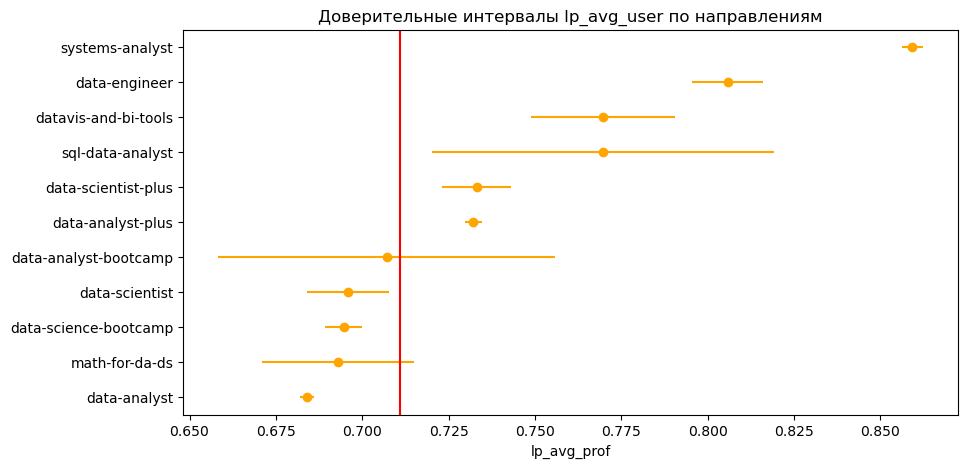

In [130]:
df_agg = df.groupby("profession_name")["lp_avg_user"].agg(["mean","std","count"]).reset_index()

alpha = 0.01
df_agg["t"] = df_agg["count"].apply(lambda x: stats.t(x-1).ppf(1 - alpha))
df_agg["step"] = df_agg["t"] * df_agg["std"] / np.sqrt(df_agg["count"])

center = df_agg.sort_values(by="mean")["mean"]
step = df_agg["step"]

mu = df.lp_avg_user.mean()

plt.figure(figsize=(10,5))
plt.errorbar(center,np.arange(center.size), xerr=step,capsize=0,fmt="o",color="orange")
plt.yticks(np.arange(center.size - 1, -1, -1),df_agg.sort_values(by="mean",ascending=False)["profession_name"])
plt.axvline(mu,0,color="red")
plt.xlabel("lp_avg_prof")
plt.title("Доверительные интервалы lp_avg_user по направлениям")
plt.show()

In [131]:
fig = px.box(df, 
             x="profession_name", 
             y="lp_avg_user", 
             color="profession_name",
             boxmode="overlay",
             color_discrete_sequence=px.colors.qualitative.Pastel2
      )

grph.layout_style(fig=fig,
                  title="Эффективность обучения по направлениям",
                  xaxis_title="Направление",
                  yaxis_title="Эффективность обучения") \
    .update_xaxes(categoryorder="total descending") \
    .update_yaxes(showgrid=False) 

fig.update_layout(showlegend=True,width=800,height=400)
fig.show(config={"displayModeBar": False})

Вывод по графику - По направлению `systems-analyst` - наиболее высокое значения и медианное значение - 0.86

Имеются выбросы с низкими значениями.

Наиболее однородный размах по направлениям `data-analyst`, `data-scientist`.

# Сегментация

In [132]:
# создание таблицы с сегментами

prof_list = df["profession_name"].unique().tolist() 
segment_list = df["current_segment"].unique().tolist()

# задаем направления и сегменты
s = SegmentUsers(df=df,
                 prof_list=prof_list,
                 segment_list=segment_list)

# создаем df
dffff = pd.DataFrame(columns = [
    "user_segment" , "user_answer", "profession_name", "segment", "pop", 
    "learning_performance_avg" , "confidence_avg", "transfer_segment_avg", 
    "transfer_cohort_avg", "question_title", "recommendation_avg"
    ]
)

# для каждого сегмента
for answer in tqdm(q["user_answer_1"]):
  s.make_table(dataframe=dffff,user_answer=answer)

100%|██████████| 37/37 [00:13<00:00,  2.77it/s]


In [133]:
# флаги

dffff["user_answer_flag"] = LabelEncoder().fit_transform(dffff["user_answer"])
dffff["user_answer"] = dffff["user_answer"].map(customwrap)

dffff = dffff[dffff["pop"] != 0]
dffff["recommendation_avg"] = dffff["recommendation_avg"].round()

dffff["flag_confidence"] = pd.qcut(
    dffff["confidence_avg"], 
    q=4, 
    labels=["Низкая уверенность", "Есть неуверенность", "Уверены", "Абсолютно уверены"]
)

dffff["flag_learning_performance"] = pd.qcut(
    dffff["learning_performance_avg"], 
    q=4, 
    labels=["Низкая", "Средняя", "Высокая", "Гигантская"]
)

In [134]:
p = 100 

t = (
    dffff[
        ["question_title", "user_answer", "user_answer_flag", "user_segment", 
         "flag_confidence", "flag_learning_performance", "recommendation_avg",
         "pop"
         ]
      ]
     .sort_values(by=["question_title","user_answer","pop"],ascending=False)
).query("pop > @p")

fig = go.Figure(data=[go.Table(
    columnwidth = [200,300],
    header=dict(values=list(t),
                align="left"),
    cells=dict(
        values=[
            t["question_title"], t["user_answer"], t["user_answer_flag"], 
            t["user_segment"], t["flag_confidence"], t["flag_learning_performance"],
            t["recommendation_avg"], t["pop"]
            ],
        align="left"))
])

grph.layout_style(fig=fig,
                  title=f"""Ответы на вопросы по сегментам (внутренняя таблица, где <b>pop > {p}</b>)""",
                  xaxis_title=None,
                  yaxis_title=None)

fig.update_layout(width=800,height=600)
fig.show(config={"displayModeBar": False})

In [135]:
fig = px.histogram(dffff.query("user_answer_flag == 29"), 
                   x="profession_name", 
                   y="pop", 
                   color="flag_confidence"
                   )

grph.layout_style(fig=fig,
                  title="Сегменты желающие подтянуть знания в прохождении собеседований и их уверенность",
                  xaxis_title="Направление",
                  yaxis_title="Количество") \
    .update_xaxes(categoryorder="total descending") \
    .update_yaxes(showgrid=False) 

fig.update_layout(showlegend=True,width=800,height=400)
fig.show(config={"displayModeBar": False})

Сегмент желающий подтянуть знания в прохождении собеседований у `data-scientist` преобладает неуверенность.

Выберем самые интересные ответы, например "сменить работу"

In [136]:
fig = px.sunburst(
    dffff.query("user_answer_flag == 33"), 
    path=["user_answer","flag_confidence", "profession_name"], 
    values="pop", 
    color="profession_name",
    width=650,
    height=500,
)
fig.update_layout(title=go.layout.Title(
    text="""
    Сегменты с целью сменить работу
    <br><sup>
    </sup>""")
)

fig.update_traces(textinfo="label+percent entry")
fig.show(config={"displayModeBar": False})

`btg` сегмент по направлениям `data-analyst` и `data-scientist` в целом наболее заинтересованы в смене работы.   
`data-scientist` - неуверенны в своих силах.

In [137]:
fig = px.sunburst(
    dffff.query("user_answer_flag == 24"), 
    path=["user_answer", "flag_learning_performance", "profession_name", "segment"], 
    values="pop", 
    color="profession_name",
    width=650,
    height=500,
)
fig.update_layout(title=go.layout.Title(
    text="""
    Сегменты которым необходима оценка шансов на трудоустройство
    <br><sup>
    </sup>""")
)
fig.update_traces(textinfo="label+percent entry")
fig.show(config={"displayModeBar": False})

Из графика оценки шансов на трудоустройство можно сделать вывод, что преобладает средняя оценка - 1548, при этом у основной доли  этой оценки -тип оплаты `b2g`.

In [138]:
fig = px.sunburst(
    dffff.query("user_answer_flag == 31 & pop > 15"), 
    path=["user_answer", "flag_confidence", "profession_name", "segment"], 
    values="pop",

    color="profession_name",
    width=650,
    height=500,
)
fig.update_layout(title=go.layout.Title(
    text="""
    Сегменты которым необходимо поработать над резюме
    <br><sup>
    </sup>""")
)
fig.update_traces(textinfo="label+percent entry")
fig.show(config={"displayModeBar": False})

Сегменты которым необходимо поработать над резюме в основном имеют среднюю успеваемость, с гигантской успеваемостью выделяются `systems-analyst`.

In [139]:
fig = px.histogram(dffff.query("question_title == 'goal'"), 
                   x="user_answer", 
                   y="pop", 
                   color = "profession_name",
                   color_discrete_sequence=px.colors.qualitative.Pastel2
                   )

grph.layout_style(fig=fig,
                  title="Какие цели у студентов",
                  yaxis_title="Количество",
                  xaxis_title="Цели") \
    .update_yaxes(categoryorder="total ascending") \
    .update_xaxes(showgrid=False) \
    .update_layout(uniformtext_minsize=8, xaxis_tickangle=-45)

fig.update_layout(showlegend=True,width=800,height=500)
fig.show(config={"displayModeBar": False})

Основная цель у студентов сменить работу. 

In [140]:
popl = (
    df
    .query("question_title_1 == 'work'")
    .groupby(
        [
            "question_title_1",
            "user_answer_1",
            "profession_name",
            "current_segment"
        ],as_index=False)
    .agg(
        {
            "user_id":"nunique"
        }
        )
    .rename(columns={"user_id":"pop"})
    .sort_values(by="pop",ascending=False)
)
popl

fig =  px.bar(popl, 
                   x="profession_name", 
                   y="pop", 
                   color = "user_answer_1",
                   color_discrete_sequence=px.colors.qualitative.Pastel2,
              barmode="group"
                   )

grph.layout_style(fig=fig,
                  title="Нашел ли студент работу за время обучения",
                  yaxis_title="Количество ответов",
                  xaxis_title="Направление") \
    .update_yaxes(categoryorder="total ascending") \
    .update_xaxes(showgrid=False) \
    .update_layout(uniformtext_minsize=8, uniformtext_mode='hide') \
    .update_layout(uniformtext_minsize=8, xaxis_tickangle=-45)

fig.update_layout(showlegend=True,width=800,height=500)
fig.show(config={"displayModeBar": False})

За время обучения малое количество студентов нашли работу.

In [141]:
fig = px.histogram(dffff.query("question_title == 'help'"), 
                   x="user_answer", 
                   y="pop", 
                   color = "profession_name",
                   color_discrete_sequence=px.colors.qualitative.Pastel2
                   )

grph.layout_style(fig=fig,
                  title="С чем необходимо помочь студенту🦄",
                  xaxis_title="Ответ",
                  yaxis_title="Количество ответов") \
    .update_yaxes(categoryorder="total ascending") \
    .update_xaxes(showgrid=False) \
    .update_layout(uniformtext_minsize=8, xaxis_tickangle=-45)

fig.update_layout(showlegend=True,width=800,height=500)
fig.show(config={"displayModeBar": False})

Топ запрос по которому необходима помощь, это - резюме, портфолио и прохождение собеседований.

In [142]:
fig = px.histogram(dffff.query("question_title == 'experience'"), 
                   x="user_answer", 
                   y="pop", 
                   color = "flag_learning_performance",
                   color_discrete_sequence=px.colors.qualitative.Pastel2
                   )

grph.layout_style(fig=fig,
                  title="Какой опыт у студентов",
                  yaxis_title="Количество ответов",
                  xaxis_title="Ответ") \
    .update_yaxes(categoryorder="total ascending") \
    .update_xaxes(showgrid=False) \
    .update_layout(uniformtext_minsize=8, xaxis_tickangle=-45)

fig.update_layout(showlegend=True,width=800,height=500)
fig.show(config={"displayModeBar": False})

Основная часть обучающихся не имеют опыта в it.

In [143]:
fig = px.histogram(df,
                   x="user_answer_2", 
                   color="current_segment", 
                   color_discrete_sequence=px.colors.qualitative.Pastel2
      )

grph.layout_style(fig=fig,
                  title="Как студенты оценивают Яндекс практикум",
                  xaxis_title="Оценка",
                  yaxis_title="Количество") \
    .update_yaxes(showgrid=False) 

fig.update_layout(showlegend=True,width=600, height=500)
fig.show(config={"displayModeBar": False})

Оценки преимущественно высокие.




# Кластеризация с помощью KMeans

**Подготовка данных**

Добавим параметр `counts_user`, который отражает сколько раз каждый пользователь втречается в таблице и удалим дубликаты.

In [144]:
t = df.copy()
for k in t['user_id'].unique():
  t.loc[t['user_id']==k,'counts_user'] = t['user_id'].value_counts()[k]
t = t.drop_duplicates()

In [145]:
t_safe = t.copy()
t = (t_safe[[
              'current_segment',
              'original_segment',
              'profession_name',
              'lp_avg_user',
              'value',
              'flag_segment_transfer',
              'flag_cohort_transfer',
              'counts_user']]
      .drop_duplicates().reset_index(drop=True))
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   current_segment        3262 non-null   object 
 1   original_segment       3262 non-null   object 
 2   profession_name        3286 non-null   object 
 3   lp_avg_user            3129 non-null   float64
 4   value                  3129 non-null   float64
 5   flag_segment_transfer  3286 non-null   int32  
 6   flag_cohort_transfer   3286 non-null   int32  
 7   counts_user            3286 non-null   float64
dtypes: float64(3), int32(2), object(3)
memory usage: 179.8+ KB


In [146]:
fig = px.histogram(t['counts_user'])

grph.layout_style(fig=fig,
                  title="Количество ответов на вопросы",
                  yaxis_title="Количество",
                  xaxis_title=None) \
    .update_yaxes(categoryorder="total ascending") \
    .update_yaxes(showgrid=False) 

fig.update_layout(showlegend=False,width=800,height=400)
fig.show(config={"displayModeBar": False})

In [147]:
t['counts_user'].value_counts().head(10)

counts_user
17.0    549
12.0    302
11.0    295
10.0    280
13.0    263
9.0     261
16.0    256
14.0    247
15.0    220
8.0     211
Name: count, dtype: int64

In [148]:
pd.isna(np.nan_to_num(X)).sum() 

0

Большинство пользователей отвечало на вопросы 17 раз.
- Переведем категориальные данные и пропуски в числовой формат. Затем проведем форматирование с помощью `StandartScaler` и `PCA`.

In [149]:
t_labels = pd.get_dummies(t.drop(columns='counts_user').dropna())
X = np.nan_to_num(t_labels)
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=0.9, random_state = R)
X_embedding_pca = pca.fit_transform(X_scaled)

fig = px.scatter_3d(
    X_embedding_pca, x=0, y=1, z=2,
    labels={'color':'species'},title = 'Визуализация Признаков на 3D Плоскости'
)
fig.update_traces(marker_size=1)
fig.show()

Сложно выделить чёткие группы, но можно выделить от 2 до 8 сегментов

**Подбор оптимального количества кластеров**

Выберем оптимальный кластер "методом локтя"

In [150]:
K = range(1, 15)
distortion = []
for k in K:
    model = KMeans(n_clusters=k, random_state=12345, n_init = 2)
    model.fit(X) 
    print('Число кластеров:', k)
    print('Значение целевой функции', model.inertia_)
    distortion.append(model.inertia_)

fig = px.line(x = K, y = distortion, markers=True)

grph.layout_style(fig=fig,
                  title="Подбор оптимального количества кластеров 'Методом локтя'",
                  yaxis_title="Значение целевой функции",
                  xaxis_title="Число кластеров") \
    .update_yaxes(showgrid=False) 

fig.update_layout(showlegend=False,width=800,height=500)
fig.show(config={"displayModeBar": False})

Число кластеров: 1
Значение целевой функции 7892.896029991352
Число кластеров: 2
Значение целевой функции 4856.675557829216
Число кластеров: 3
Значение целевой функции 3973.8592895284405
Число кластеров: 4
Значение целевой функции 3275.0444712772246
Число кластеров: 5
Значение целевой функции 2778.4039837631553
Число кластеров: 6
Значение целевой функции 2480.84547433034
Число кластеров: 7
Значение целевой функции 2229.9462423180144
Число кластеров: 8
Значение целевой функции 2110.566062452143
Число кластеров: 9
Значение целевой функции 1873.2633249911876
Число кластеров: 10
Значение целевой функции 1767.3256859395428
Число кластеров: 11
Значение целевой функции 1723.5051861109653
Число кластеров: 12
Значение целевой функции 1500.3801384447502
Число кластеров: 13
Значение целевой функции 1407.1650213443136
Число кластеров: 14
Значение целевой функции 1335.0258454286504


Нет ярко выраженной "точки локтя", но оптимальным выглядит разделение на 2-4 сегмента. 

In [153]:
num_cols = t.columns[3:8]

def KM (df=t,X=X,n_clusters=2):
  model = KMeans(n_clusters=n_clusters, random_state=12345, init='k-means++',n_init = 'auto')
  model.fit(X) 
  labels = model.labels_
  df[f'km_{n_clusters}_clusters'] = labels
  return df

def clust_groupby(columns,n=2,df=t.dropna()):
  KM(df,X,n)
  return df.groupby([f'km_{n}_clusters']+columns)[num_cols].agg({
                                                                      'lp_avg_user':['mean'],
                                                                      'value':'median',
                                                                      'flag_segment_transfer':'median',
                                                                      'flag_cohort_transfer':'median',
                                                                      "counts_user": ['count','mean','median']
                                                                                            })

Рассмотрим разделение на разное количество сегментов

**2 Сегмента**

In [154]:
clust_groupby(['original_segment'],2)

lp_avg_user  value flag_segment_transfer   
                                      mean median                median   
km_2_clusters original_segment                                            
0             b2b                 0.797310    0.8                   1.0  \
              b2c                 0.731718    1.0                   1.0   
1             b2b                 0.647116   -0.2                   1.0   
              b2g                 0.691291    1.0                   1.0   

                               flag_cohort_transfer counts_user              
                                             median       count       mean   
km_2_clusters original_segment                                               
0             b2b                               1.0           7   9.714286  \
              b2c                               1.0        1442  12.043689   
1             b2b                               1.0          13   7.923077   
              b2g                               1.0        1667  12.760648   

                                       
                               median  
km_2_clusters original_segment         
0             b2b                 9.0  
              b2c                12.0  
1             b2b                 9.0  
              b2g                13.0

В данной таблице можно посмотреть количество в каждой группе в стобце counts_user - подстолбец count

При разбиении на 2 кластера модель делит пользователей по начальному сегменту оплаты:
- **0  Сегмент**: **b2g**
- **1 Сегмент**: **b2c**

**3 Сегмента**

In [155]:
clust_groupby(['original_segment','profession_name'],3)

lp_avg_user     value   
                                                            mean    median   
km_3_clusters original_segment profession_name                               
0             b2b              data-analyst-plus        0.737143  0.666667  \
                               data-scientist           0.930000  0.777778   
                               sql-data-analyst         0.435000  1.000000   
                               systems-analyst          0.869757  0.650000   
              b2c              data-analyst             0.684552  1.000000   
                               data-analyst-bootcamp    0.725000  1.000000   
                               data-analyst-plus        0.725641  1.250000   
                               data-engineer            0.800639  1.166667   
                               data-science-bootcamp    0.710000  1.500000   
                               data-scientist           0.689542  1.000000   
                               data-scientist-plus      0.728211  1.000000   
                               datavis-and-bi-tools     0.769048  1.285714   
                               math-for-da-ds           0.682933  1.750000   
                               sql-data-analyst         0.762458  1.250000   
                               systems-analyst          0.860860  1.333333   
1             b2b              data-analyst             0.500000  1.500000   
                               data-scientist           0.671667  1.833333   
                               sql-data-analyst         0.930000  2.000000   
              b2g              data-analyst             0.682176  1.200000   
                               data-analyst-plus        0.738727  1.250000   
                               data-scientist           0.705518  1.333333   
                               data-scientist-plus      0.739506  1.333333   
2             b2b              data-analyst             0.618692 -0.200000   
                               data-scientist           0.624683 -0.500000   
              b2c              data-analyst             0.656611 -1.000000   
                               data-analyst-plus        0.760250 -1.000000   
                               data-scientist           0.666449 -1.166667   
                               data-scientist-plus      0.552639 -1.000000   
                               sql-data-analyst         0.777222 -1.250000   
                               systems-analyst          0.816835 -1.000000   
              b2g              data-analyst             0.677243  0.000000   
                               data-analyst-plus        0.728300  0.000000   
                               data-scientist           0.682291 -0.142857   
                               data-scientist-plus      0.930000 -0.600000   

                                                     flag_segment_transfer   
                                                                    median   
km_3_clusters original_segment profession_name                               
0             b2b              data-analyst-plus                       1.0  \
                               data-scientist                          1.0   
                               sql-data-analyst                        1.0   
                               systems-analyst                         1.0   
              b2c              data-analyst                            1.0   
                               data-analyst-bootcamp                   1.0   
                               data-analyst-plus                       1.0   
                               data-engineer                           1.0   
                               data-science-bootcamp                   1.0   
                               data-scientist                          1.0   
                               data-scientist-plus                     1.0   
                               datavis-and-bi-tools                    1.0

При разбиении на 3 кластера, получились следующие сегменты:
- **0-й Сегмент:** `data-scientist` из сектора **b2g**
- **1-й Сегмент:** Все из сектора **b2c**
- **2-й Сегмент:** `data-analyst` из сектора **b2g**


**4 Сегмента**

In [156]:
clust_groupby(['original_segment'],4)

lp_avg_user     value flag_segment_transfer   
                                      mean    median                median   
km_4_clusters original_segment                                               
0             b2b                 0.788320  0.900000                   1.0  \
              b2c                 0.736916  1.142857                   1.0   
1             b2b                 0.736250  1.333333                   1.0   
              b2g                 0.708585  1.000000                   1.0   
2             b2b                 0.500000  1.500000                   1.0   
              b2g                 0.682690  1.000000                   1.0   
3             b2b                 0.646529 -0.200000                   1.0   
              b2c                 0.699810 -0.500000                   1.0   
              b2g                 0.664000 -0.800000                   1.0   

                               flag_cohort_transfer counts_user              
                                             median       count       mean   
km_4_clusters original_segment                                               
0             b2b                               1.0           6   9.833333  \
              b2c                               1.0        1240  12.052419   
1             b2b                               0.5           4   7.750000   
              b2g                               1.0         680  13.127941   
2             b2b                               1.0           1  11.000000   
              b2g                               1.0         812  12.561576   
3             b2b                               1.0           9   7.777778   
              b2c                               1.0         202  11.990099   
              b2g                               1.0         175  12.257143   

                                       
                               median  
km_4_clusters original_segment         
0             b2b                10.5  
              b2c                12.0  
1             b2b                 9.0  
              b2g                13.0  
2             b2b                11.0  
              b2g                13.0  
3             b2b                 8.0  
              b2c                12.0  
              b2g                12.0

In [157]:
clust_groupby(['original_segment','profession_name'],4)

lp_avg_user     value   
                                                            mean    median   
km_4_clusters original_segment profession_name                               
0             b2b              data-analyst-plus        0.737143  0.666667  \
                               sql-data-analyst         0.682500  1.500000   
                               systems-analyst          0.875926  0.800000   
              b2c              data-analyst             0.684752  1.000000   
                               data-analyst-bootcamp    0.719688  1.000000   
                               data-analyst-plus        0.722575  1.333333   
                               data-engineer            0.803424  1.333333   
                               data-science-bootcamp    0.710000  1.500000   
                               data-scientist           0.689645  1.000000   
                               data-scientist-plus      0.727149  1.000000   
                               datavis-and-bi-tools     0.769048  1.285714   
                               math-for-da-ds           0.662000  1.875000   
                               sql-data-analyst         0.761207  1.267857   
                               systems-analyst          0.861592  1.400000   
1             b2b              data-scientist           0.736250  1.333333   
              b2g              data-analyst-plus        0.735373  1.250000   
                               data-scientist           0.704331  1.000000   
                               data-scientist-plus      0.739506  1.333333   
2             b2b              data-analyst             0.500000  1.500000   
              b2g              data-analyst             0.682690  1.000000   
3             b2b              data-analyst             0.618692 -0.200000   
                               data-scientist           0.624683 -0.500000   
                               systems-analyst          0.851250  0.333333   
              b2c              data-analyst             0.673653 -0.500000   
                               data-analyst-bootcamp    0.810000 -0.555556   
                               data-analyst-plus        0.765062 -0.583333   
                               data-engineer            0.770000 -0.666667   
                               data-scientist           0.682655 -0.225000   
                               data-scientist-plus      0.675528 -0.333333   
                               math-for-da-ds           0.766667 -0.500000   
                               sql-data-analyst         0.786667 -1.000000   
                               systems-analyst          0.838003 -0.500000   
              b2g              data-analyst             0.653323 -0.800000   
                               data-analyst-plus        0.747644 -0.500000   
                               data-scientist           0.660139 -0.800000   
                               data-scientist-plus      0.930000 -0.600000   

                                                     flag_segment_transfer   
                                                                    median   
km_4_clusters original_segment profession_name                               
0             b2b              data-analyst-plus                       1.0  \
                               sql-data-analyst                        1.0   
                               systems-analyst                         1.0   
              b2c              data-analyst                            1.0   
                               data-analyst-bootcamp                   1.0   
                               data-analyst-plus                       1.0   
                               data-engineer                           1.0   
                               data-science-bootcamp                   1.0   
                               data-scientist                          1.0   
                               data-scientist-plus                     1.0

При разбиении на 4 кластера, получились следующие сегменты: 
- **0-й Сегмент:** `data-scientist` из сектора **b2g**
- **1-й Сегмент:** Люди из сектора **b2c**, которые могут применить полученные знания (высоким параметром **value**, медиана = 1.5) и высокой эффективностью обучения (**lp_avg_user**).
- **2-й Сегмент:** `data-analyst` из сектора **b2g**
- **3-й Сегмент:** Студенты из сектора **b2c**, которые сомневаются в полученных знаниях (медийный параметр **value** = 0) и эффективностью обучения (**lp_avg_user**) ниже среднего.


**5 сегментов**

In [158]:
clust_groupby(['original_segment'],5)

lp_avg_user     value flag_segment_transfer   
                                      mean    median                median   
km_5_clusters original_segment                                               
0             b2b                 0.721444  1.500000                   1.0  \
              b2c                 0.749767  1.500000                   1.0   
              b2g                 0.597236  1.761905                   0.0   
1             b2b                 0.671667  1.833333                   1.0   
              b2g                 0.703507  1.666667                   1.0   
2             b2g                 0.683227  0.666667                   1.0   
3             b2b                 0.701012 -0.350000                   1.0   
              b2g                 0.685593  0.000000                   1.0   
4             b2b                 0.695926 -0.100000                   1.0   
              b2c                 0.700754  0.000000                   1.0   
              b2g                 0.640756 -1.000000                   0.0   

                               flag_cohort_transfer counts_user              
                                             median       count       mean   
km_5_clusters original_segment                                               
0             b2b                               1.0           5   9.800000  \
              b2c                               1.0         911  12.098793   
              b2g                               1.0          10   9.500000   
1             b2b                               0.0           3  10.000000   
              b2g                               1.0         682  13.033724   
2             b2g                               1.0         624  12.583333   
3             b2b                               1.0           4   6.500000   
              b2g                               1.0         343  12.647230   
4             b2b                               1.0           8   8.250000   
              b2c                               1.0         531  11.949153   
              b2g                               1.0           8  12.250000   

                                       
                               median  
km_5_clusters original_segment         
0             b2b                11.0  
              b2c                12.0  
              b2g                10.5  
1             b2b                 9.0  
              b2g                13.0  
2             b2g                13.0  
3             b2b                 7.5  
              b2g                12.0  
4             b2b                 8.5  
              b2c                12.0  
              b2g                11.5

In [159]:
clust_groupby(['original_segment','profession_name'],5)

lp_avg_user     value   
                                                            mean    median   
km_5_clusters original_segment profession_name                               
0             b2b              data-analyst             0.500000  1.500000  \
                               sql-data-analyst         0.682500  1.500000   
                               systems-analyst          0.871111  1.150000   
              b2c              data-analyst             0.691714  1.400000   
                               data-analyst-bootcamp    0.743333  1.000000   
                               data-analyst-plus        0.723404  1.500000   
                               data-engineer            0.834667  1.600000   
                               data-science-bootcamp    0.706000  2.000000   
                               data-scientist           0.688542  1.500000   
                               data-scientist-plus      0.744554  1.500000   
                               datavis-and-bi-tools     0.693571  1.392857   
                               math-for-da-ds           0.646000  2.000000   
                               sql-data-analyst         0.765730  1.333333   
                               systems-analyst          0.863861  1.500000   
              b2g              data-analyst             0.597236  1.761905   
1             b2b              data-scientist           0.671667  1.833333   
              b2g              data-analyst             0.689246  1.800000   
                               data-analyst-plus        0.732975  1.333333   
                               data-scientist           0.705932  1.464286   
                               data-scientist-plus      0.752508  1.750000   
2             b2g              data-analyst             0.681383  0.666667   
                               data-analyst-plus        0.767990  0.500000   
                               data-scientist-plus      0.694000  0.625000   
3             b2b              data-scientist           0.701012 -0.350000   
              b2g              data-analyst             0.616391 -1.333333   
                               data-analyst-plus        0.724109 -0.291667   
                               data-scientist           0.686856  0.000000   
                               data-scientist-plus      0.930000 -0.600000   
4             b2b              data-analyst             0.618692 -0.200000   
                               data-analyst-plus        0.737143  0.666667   
                               systems-analyst          0.868403  0.416667   
              b2c              data-analyst             0.672875  0.166667   
                               data-analyst-bootcamp    0.681000  0.250000   
                               data-analyst-plus        0.737207  0.000000   
                               data-engineer            0.753000  0.000000   
                               data-science-bootcamp    0.730000  0.500000   
                               data-scientist           0.686740  0.000000   
                               data-scientist-plus      0.689637  0.000000   
                               datavis-and-bi-tools     0.920000  0.500000   
                               math-for-da-ds           0.738333 -0.166667   
                               sql-data-analyst         0.753235  0.000000   
                               systems-analyst          0.843441  0.000000   
              b2g              data-analyst             0.640756 -1.000000   

                                                     flag_segment_transfer   
                                                                    median   
km_5_clusters original_segment profession_name                               
0             b2b              data-analyst                            1.0  \
                               sql-data-analyst                        1.0   
                               systems-analyst                         1.0

При разбиении на 5 кластеров, получились следующие сегменты: 
- **0-й Сегмент:** `data-scientist` из сектора **b2g**
- **1-й Сегмент:** Люди из сектора **b2c**, которые могут применить полученные знания (высоким параметром value, медиана = 1.5) и высокой эффективностью обучения (**lp_avg_user**).
- **2-й Сегмент:** `data-analyst` из сектора **b2g**
- **3-й Сегмент:** `data-analyst` **b2c** c невысоким медийным параметром value 0.5
- **4-й Сегмент:** `data-scientist`, `systems-analyst` и студенты расширенных программы **b2c** c невысоким медийным параметром value от 0 до 0.5.

**6 Сегментов**

In [160]:
clust_groupby(['original_segment'],6)

lp_avg_user     value flag_segment_transfer   
                                      mean    median                median   
km_6_clusters original_segment                                               
0             b2b                 0.776806  1.250000                   1.0  \
              b2c                 0.750437  1.500000                   1.0   
1             b2b                 0.736250  1.333333                   1.0   
              b2g                 0.705945  1.333333                   1.0   
2             b2b                 0.618692 -0.200000                   1.0   
              b2g                 0.682805  0.166667                   1.0   
3             b2b                 0.624683 -0.500000                   1.0   
              b2g                 0.686589  0.000000                   1.0   
4             b2b                 0.824649  0.500000                   1.0   
              b2c                 0.700909  0.000000                   1.0   
5             b2b                 0.500000  1.500000                   1.0   
              b2g                 0.687985  1.333333                   1.0   

                               flag_cohort_transfer counts_user              
                                             median       count       mean   
km_6_clusters original_segment                                               
0             b2b                               1.0           4   9.500000  \
              b2c                               1.0         897  12.094760   
1             b2b                               0.5           4   7.750000   
              b2g                               1.0         431  13.092807   
2             b2b                               1.0           5   7.200000   
              b2g                               1.0         356  12.502809   
3             b2b                               1.0           3   8.333333   
              b2g                               1.0         276  12.695652   
4             b2b                               1.0           3  10.000000   
              b2c                               1.0         545  11.959633   
5             b2b                               1.0           1  11.000000   
              b2g                               1.0         604  12.705298   

                                       
                               median  
km_6_clusters original_segment         
0             b2b                10.0  
              b2c                12.0  
1             b2b                 9.0  
              b2g                13.0  
2             b2b                 6.0  
              b2g                13.0  
3             b2b                 9.0  
              b2g                13.0  
4             b2b                 9.0  
              b2c                12.0  
5             b2b                11.0  
              b2g                13.0

In [161]:
clust_groupby(['original_segment','profession_name'],6)

lp_avg_user     value   
                                                            mean    median   
km_6_clusters original_segment profession_name                               
0             b2b              sql-data-analyst         0.682500  1.500000  \
                               systems-analyst          0.871111  1.150000   
              b2c              data-analyst             0.690650  1.500000   
                               data-analyst-bootcamp    0.743333  1.000000   
                               data-analyst-plus        0.723404  1.500000   
                               data-engineer            0.834667  1.600000   
                               data-science-bootcamp    0.706000  2.000000   
                               data-scientist           0.689348  1.500000   
                               data-scientist-plus      0.744554  1.500000   
                               datavis-and-bi-tools     0.693571  1.392857   
                               math-for-da-ds           0.646000  2.000000   
                               sql-data-analyst         0.768469  1.500000   
                               systems-analyst          0.863861  1.500000   
1             b2b              data-scientist           0.736250  1.333333   
              b2g              data-scientist           0.705945  1.333333   
2             b2b              data-analyst             0.618692 -0.200000   
              b2g              data-analyst             0.681265  0.166667   
                               data-analyst-plus        0.724590  0.333333   
                               data-scientist-plus      0.623000  0.500000   
3             b2b              data-scientist           0.624683 -0.500000   
              b2g              data-analyst-plus        0.747644 -0.500000   
                               data-scientist           0.683608  0.000000   
                               data-scientist-plus      0.930000 -0.600000   
4             b2b              data-analyst-plus        0.737143  0.666667   
                               systems-analyst          0.868403  0.416667   
              b2c              data-analyst             0.674800  0.183333   
                               data-analyst-bootcamp    0.681000  0.250000   
                               data-analyst-plus        0.737207  0.000000   
                               data-engineer            0.753000  0.000000   
                               data-science-bootcamp    0.730000  0.500000   
                               data-scientist           0.685976  0.000000   
                               data-scientist-plus      0.689637  0.000000   
                               datavis-and-bi-tools     0.920000  0.500000   
                               math-for-da-ds           0.738333 -0.166667   
                               sql-data-analyst         0.745250  0.000000   
                               systems-analyst          0.843441  0.000000   
5             b2b              data-analyst             0.500000  1.500000   
              b2g              data-analyst             0.680491  1.375000   
                               data-analyst-plus        0.737561  1.333333   
                               data-scientist-plus      0.754069  1.541667   

                                                     flag_segment_transfer   
                                                                    median   
km_6_clusters original_segment profession_name                               
0             b2b              sql-data-analyst                        1.0  \
                               systems-analyst                         1.0   
              b2c              data-analyst                            1.0   
                               data-analyst-bootcamp                   1.0   
                               data-analyst-plus                       1.0   
                               data-engineer                           1.0

При разбиении на 6 кластеров, получились следующие сегменты: 
- **0-й Сегмент:** `data-scientist` из сектора **b2g**
- **1-й Сегмент:** `systems-analyst` **b2c.**
- **2-й Сегмент:** `data-analyst` из сектора **b2g**
- **3-й Сегмент:** **b2c** `data-analyst`  c низким медийным параметром value 0.25
- **4-й Сегмент:** **b2c** `data-scientist`, `systems-analyst` и студенты расширенных программы c невысоким медийным параметром value от 0 до 0.35
- **5-й Сегмент** **b2c** `data-scientist`, `systems-analyst` и студенты расширенных программы c высоким медийным параметром value от 1 до 2.

# Общий вывод по всей работе

Был проведен **EDA** данных и сегментация студентов, также проведена поочерёдная кластеризация на сегменты (от 2 до 6). Имеются следующие выводы по работе модели.

- Первое разделение производиться по сегменту оплаты, первым делом модель делит студентов на **b2c** и **b2g**.
- Следующим идёт выделение двух больших групп в данных категория - `data-analyst` и `data-scientists`. Т.е. модель проводит группировку по направлению обучения.
- Затем идёт разделение студентов по показателям **value** и **lp_avg** на высокие (value больше 1.5) и низкие (**value** от 0 до 0.5) 

Большинство студентов можно разделить на следующие сегменты:
 - 1) **b2g** `data-analyst`
 - 2) **b2g** `data-scientist`
 - 3) **b2c** `data-analyst`
 - 4) **b2c** `data-scientist`
 - 5) Все остальные (**b2b**, `systems-analyst` и направления для людей "с опытом")

И так же каждый сегмент делиться на тех кто уверен в полученных знания **value** (1.5-2) и тех кто сомнемается (0-0.5). Притом, что примерно треть студентов относиться к категории "сомневающихся".

- Так же стоит отметить, что медийное value и lp студентов **b2b** выше - что говорит об более высокой удволетворённости обучением.
- `data-scientist` же наоборот чаще имеет более низкий показатель **lp** и **value**, чем аналитики.


**Гипотезы:**

1.  Уверенность в своих знаниях растет по мере появления определенного багажа знаний, т.е определенного перечня пройденных курсов.
2. Студенты из сегмента **b2b** дают наибольшую оценку своей успеваемости и уверенности в знаниях.
3. В повышении уверенности в своих знаниях и уверенности в успешном поиске работы огромную роль - получение практического опыта в составлении резюме, портфолио, решением тестовых. Наработка навыков в применении своих знаний- написание собственных проектов и участие в разных конференциях,митапах.


**Основные цели студентов в обучении:**

1. Сменить или найти работу
2. Получить новые знания
3. Получить повышение по карьерной лестнице.


# Портреты студентов

**Портреты студентов:**
- 1) **49.5%** - B2G или B2C Дата-Аналитик или Дата-Сайентист, который обладает уверенностью в полученных знаниях и с оценкой эффективности обучения выше среднего. Собирается пойти в карьерный трек для того чтобы сменить работу или же пришёл на обучение для повышения квалификации.
- 2) **28.7%** - B2G или B2C Дата-Сайентист (реже Дата-Аналитик) без опыта работы в IT, который не обладает уверенностью в полученных знаниях и с низкой оценкой эффективности обучения. Пришёл чтобы сменить работу и планирует пойти в карьерный трек. 
- 3) **9.8%** - B2C Системный аналитик, который обладает абсолютной уверенностью в полученных знаниях о очень высокой оценкой эффективности обучения.

*Также можно выделить ещё 2 полноценных портрета:*
- 4) **11.3%** - B2C и B2G студент, который учиться на расширенной программе "плюс" или на направлении с пометкой "с опытом" или прокачивает навыки (SQL). Обладает высокой уверенностью в полученных знаниях и высокой оценкой эффективности обучения.
- 5) **0.7%** - студент из сегмента B2B так же обладает высокой оценкой эффективности обучения и большей уверенностью в полученных знаниях. 


Гипотезы и предложения по портретам студентов:

- 1) **Сегмент “неуверенных” специалистов по Data Science.** 
На курсе по DS выпускники погружаются в тему машинного обучения и знакомятся с различным направлениями этой профессии такими как CV (Компьютерное зрение) и NLP (Распознавание текста), анализ данных, работа с бизнесом, линейная алгебра. 
  -  *Гипотеза:* студенты DS видят, что являются новичками в каждом направлении и понимают, что есть ещё огромный пласт непройденного материала и поэтому чувствуют сильную неуверенность в своих знаниях. На Яндекс.Практикуме в данный момент нет курсов повышения квалификации для DS и студенты не знают где им дальше учиться, чтобы восполнить недостаток в знаниях.
  *Предложение:*
Добавить мини-курсы по направлениям CV, NLP, Deep Learning. Тогда студенты после обучения смогут выбрать курс, который подходит им.
Добавить базу знаний с материалами по DS по каждому направлению.

- 2) **В противоположность “неуверенным Дата-Сайентистам” есть абсолютно уверенные и успешные системные аналитики.**
  - *Гипотеза:* сейчас системные аналитики пользуются большим спросом - на джоббордах часто можно увидеть эту вакансию, поэтому студенты уверены что смогут использовать полученные навыки в работе. Но не стоит исключать, что в будущем соотношение спрос-предложение может измениться и в этой сфере наступит высокая конкуренция, что впоследствии может привести к уменьшению уверенности в этом сегменте. Но на данный момент этот сегмент выглядит перспективно.
  - Предложение: 
Также рассмотреть возможность создания курса по повышению квалификации системного аналитика.
- 3) **Студенты B2B.**
 - *Гипотеза:* сейчас студентов из этого сегмента немного, но они чувствуют большую уверенность и обладают более высокой успеваемостью, чем B2G и B2C. Вероятно, что студенты, которым работодатель оплачивает обучение чувствуют себя намного спокойнее, потому что уже работают в сфере, а также могут продвинуться по карьере благодаря курсам.
  - *Предложение:* приглядеться к этому сегменту,  привлечение B2B может быть выгодным.